# Lab05 - Sparsity Aware Learning
Author: [Yunting Chiu](https://www.linkedin.com/in/yuntingchiu/)


# Install the required packages

In [1]:
import imageio
import cv2
import matplotlib.pyplot as plt
import math
from scipy.io import loadmat
from google.colab.patches import cv2_imshow
import numpy as np
import os
import sys
from sklearn.linear_model import Lasso
from skimage.util import view_as_windows as viewW

# Read the image
Before we start, we read the image to see what does it looks like. Because it is a grayscale image, so the image is 2 deminsions.

float32 (256, 256)


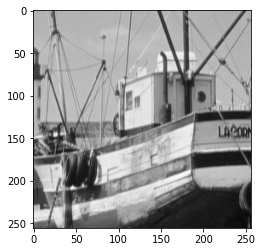

In [2]:
# read the image
path = "/content/drive/MyDrive/American_University/2021_Fall/DATA-642-001_Advanced Machine Learning/GitHub/Labs/05/boats.mat"
y_exact = loadmat(path, variable_names = 'boats').get('boats')
y_exact = np.array(y_exact, dtype=np.float32)
plt.imshow(y_exact, cmap='gray')
print(y_exact.dtype, y_exact.shape)

# Define the functions
- `im2col` is one of MATLAB functions that rearranges image blocks into columns. There is no existing function supporting in Python, so we need to define a new one. For more detail: https://www.mathworks.com/help/images/ref/im2col.html
- `waitbar` is used for tracking the process when we run the code.


In [3]:
# Note: BSZ is designed as a 2D array
def im2col(A, BSZ, stepsize=1):
  return viewW(A, (BSZ[0], BSZ[1])).reshape(-1, BSZ[0]*BSZ[1]).T[:, ::stepsize]

In [4]:
def waitbar(count, total, suffix=''):
  bar_len = 40
  filled_len = int(round(bar_len * count / float(total)))
  percents = round(100.0 * count / float(total), 1)
  bar = '=' * filled_len + '-' * (bar_len - filled_len)
  sys.stdout.write('\t[%s] %s%s\t%s\r' % (bar, 100*percents, '%', suffix))
  sys.stdout.flush()

# Generate some noises into the image
Now, the original image and the noised image look like

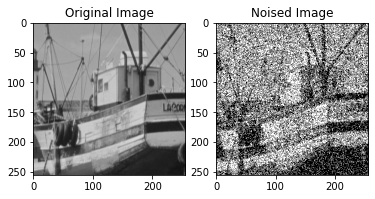

In [20]:
# print(y_exact)
sigma = 100
# Construct a noisy version of the original image, adding the noise in each pixel
y_noise = y_exact + np.random.randn(y_exact.shape[0], y_exact.shape[1])*sigma
blocksize = 12 # block size
K = 14**2 # number of atoms in the dictionary
Y = im2col(y_noise, BSZ=(blocksize, blocksize))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(y_exact, cmap='gray', vmin=0, vmax=255)
plt.subplot(1, 2, 2)
plt.title('Noised Image')
plt.imshow(y_noise, cmap='gray', vmin=0, vmax=255)

And the shape that we rearranged the image blocks into columns is

In [6]:
print(Y.shape)

(144, 60025)


# Construct a fixed dictionary

In [12]:
n = np.array(range(0, blocksize))
DCT = np.zeros(shape = (blocksize, int(math.sqrt(K))))
for k in range(0, int(math.sqrt(K))):
  V = np.cos(n.conj().transpose()*k*np.pi/math.sqrt(K))
  DCT[:, k] = V/np.linalg.norm(V)

DCT = np.kron(DCT, DCT) # Kronecker product of two arrays
Dict_fixed = DCT
for k in range(0, Dict_fixed.shape[1]):
  Dict_fixed[:, k] = Dict_fixed[:, k]/np.linalg.norm(Dict_fixed[:, k])
print(Dict_fixed.shape)

(144, 196)


# Denoising using Lasso

In [14]:
Y_reconst = np.zeros(shape=Y.shape)
subproblems = Y.shape[1]
waitbar(0, 100, 'Please wait...')
for i in range(0, Y.shape[1]):
  if i % 100 == 0:
    waitbar(i/subproblems, 100, 'Please wait...')
  G = Lasso(fit_intercept=False, normalize=False, alpha = 0.4).fit(Dict_fixed, Y[:, i])
  Y_reconst[:, i] = np.dot(Dict_fixed, G.coef_)
sys.stdout.flush()
print('')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 326.7943129981286, tolerance: 176.96141052440774
  positive)


## Exercise 3

8.148905478448915
12.923361184297825


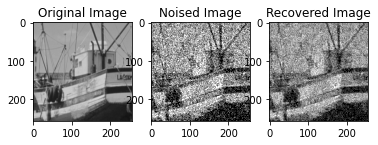

In [19]:
# ========================================================
# this is a Python implementation of the code contained in Chapter_15_CoreInpaining1.m of Elad's book
# "Sparse and Redundant Representations: From Theory to Applications in Signal and Image Processing", 
# Springer, 2010
# ========================================================
N = y_exact.shape[0]
n = blocksize
yout = np.zeros(shape=(N, N))
Weight = np.zeros(shape=(N, N))
i = 0
j = 0
for k in range(0, (N-n+1)**2):
  patch = np.reshape(Y_reconst[:, k], newshape=(n, n))
  yout[i:(i+n), j:(j+n)] += patch
  Weight[i:(i+n), j:(j+n)] += 1
  if j < (N-n):
    j += 1
  else:
    j = 0
    i += 1
recovered_boat_dct = np.divide(yout, Weight)
print(20*np.log10(255 * np.sqrt(y_exact.shape[0]*y_exact.shape[1]) / np.linalg.norm(y_exact-y_noise)))
print(20*np.log10(255 * np.sqrt(y_exact.shape[0]*y_exact.shape[1]) / np.linalg.norm(y_exact-recovered_boat_dct)))
plt.figure(1)
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(y_exact, cmap='gray', vmin=0, vmax=255)
plt.subplot(1, 3, 2)
plt.title('Noised Image')
plt.imshow(y_noise, cmap='gray', vmin=0, vmax=255)
plt.subplot(1, 3, 3)
plt.title('Recovered Image')
plt.imshow(recovered_boat_dct, cmap='gray', vmin=0, vmax=255)
plt.show()